# LSTM baseline

from kuto

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [3]:
import os
import sys
import glob
import pickle
import random

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [5]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [6]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [7]:
sys.path.append('../../')
import src.utils as utils

In [8]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [9]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [10]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [11]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 200
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 25
IS_SAVE = True

utils.set_seed(SEED)

In [12]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [13]:
train_df = pd.read_csv(WIFI_DIR / 'train_10.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10.csv')

In [14]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [15]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [16]:
train_df.iloc[:, 100:110]

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9
0,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,591ea59cf88e3397db5d60eb00a5147edd69399a,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,a77f8e93896f8fc8bc0d0700ca04b802ee79a07f,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,3799b46aa4cf6c3c45c0bc27d8f1efefea96914f,fc6956beb062b5158252c66953e92a0d25495cac,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd
1,e9b24f94c0007acb4b7169b945622efcd332cf6f,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,1b2fd184314ae440900fa9ce1addeb896b5604a9,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9
2,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,509d1f842b0773e85c6beec0bb530542efd35cb9,b2337b25e7d1df04928bf6698a9c0b2764df7795,76f81d5047273fa64a434457531d400fc5d90fac,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,8c6ab78f2797e076f9106af81090d0ab9904f5cd,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,f920a2e4cb52165850990d9d37d391b630f7de14
3,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,0452e85d0a41780463cfe079077ea5bd2f519c7a
4,5875360455060f20a3cba705f44a4e3987c9b9f3,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,0452e85d0a41780463cfe079077ea5bd2f519c7a,3c7e7fa0576bc8a2af71d5899581df36f4dab6c8,09e103887f42552d20328aa41891cf82dace79ab,54bba3a36204f8c71b93798c31f9e0b039914575,18067f8d8861af3bcae51ba04b6b11b9150b9ff2,591ea59cf88e3397db5d60eb00a5147edd69399a,f920a2e4cb52165850990d9d37d391b630f7de14,d32dd11040b254cd889c9ead2d4a50f6e3900196
...,...,...,...,...,...,...,...,...,...,...
258120,5964a27e0cb3344b0a18540e6b3120c433971c38,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,346b34a42e801c64e043dbaacbe7fef9b8880774,4b5dbdb52b131410ea10b59ea451de62280b41d6,21310f6a93112e4cb928817e3af33ebb1bb62875,fa11fc4d4960379cb68cc6968ba6415168fef53c,89395d0ee75307b3beb30aef2f19fc680095d514,cc5250324fd7779782cf7066839a6be43bdbf72a,5f583dcccc43b5b7ac25d270e29c92d878fb2be0
258121,5964a27e0cb3344b0a18540e6b3120c433971c38,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,4b5dbdb52b131410ea10b59ea451de62280b41d6,4d2e5639041b40b0df2ee258aa504bd904133d80,f4107af4418d57aacb3542343f7b47768debdc75,5f583dcccc43b5b7ac25d270e29c92d878fb2be0
258122,346b34a42e801c64e043dbaacbe7fef9b8880774,5964a27e0cb3344b0a18540e6b3120c433971c38,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,4b5dbdb52b131410ea10b59ea451de62280b41d6,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9,ee5ca7a7deaacdcd5d99355ff5f156dc45b74efa,a7986c0cea5d2571ea42011ab4407039e977c0bd
258123,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,5964a27e0cb3344b0a18540e6b3120c433971c38,f4107af4418d57aacb3542343f7b47768debdc75,cce41299a022ada08aebf3d309acb07d5f00b014,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,a7986c0cea5d2571ea42011ab4407039e977c0bd,180a351ec58c07d60949862c534373c43f548a9a,4d2e5639041b40b0df2ee258aa504bd904133d80


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [17]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 60633
BSSID TYPES(test): 30362
BSSID TYPES(all): 90995


In [18]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 98
RSSI TYPES(test): 77
RSSI TYPES(all): 175


## preprocessing

In [20]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
#     output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_97,frequency_98,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,5745,5745,5180,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5180,2462,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5180,2452,5320,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,2452,2452,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,2452,2467,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,70ba065d6d5456835fa594d193b2f41335da9dec,0a8a55cf161bc4980194ec9f7f7a448439be4b74,da39a3ee5e6b4b0d3255bfef95601890afd80709,2f797a25b58a1ed92176550ac6770f764703401d,1f09251bbfadafb11c63c87963af25238d6bc886,...,5745,5805,5765,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23
258121,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,5805,5765,5745,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23
258122,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67b

In [21]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [22]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        feature = {
            'BSSID_FEATS':self.bssid_feats[idx],
            'RSSI_FEATS':self.rssi_feats[idx],
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [23]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, rssi_size=173, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
        self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
#         self.rssi = nn.Sequential(
#             nn.BatchNorm1d(NUM_FEATS),
#             nn.Linear(NUM_FEATS, NUM_FEATS * 64)
#         )
        
        concat_size = 64 + (NUM_FEATS * 64) + (NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)

        x_rssi = self.rssi_embedding(x['RSSI_FEATS'])
        x_rssi = self.flatten(x_rssi)

        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [24]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [25]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [26]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [27]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [28]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size, rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=10,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.445    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 136.0096893310547


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 127.90116282796888


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 102.01135459859911


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 88.31448109590667


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 82.69755601846276


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 81.2945688979738


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 61.88431296937883


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 57.59047669279069


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 54.867601534577396


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 53.11757072841976


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 51.526065557676475


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 44.13864960005621


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 37.366788302639854


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 31.70361682954054


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 27.369879531749266


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 23.70681669311879


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 20.492821420026367


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 18.105585157786543


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 16.39224738515944


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 14.485159658355357


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 13.402237119091481


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.571598054422635


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 12.380366326811428


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.28898796088208


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.801400615834329


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.50412756561608


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.410244408075936


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.250674595763394


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.04092482095273


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.888353226783321


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.63834548048176


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.143589734125776


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.810249567448434


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.5094627406032


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.970614534421376


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.085764150158498


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.269654579029295


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.127244641965534


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.184355936977983


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.364643816661891


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.301318364351658


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.244926463723113


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.24335024167718


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.221955951597362


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.1843911753384


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.20317472007987


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.194050358942794


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.199451541956178


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.191722104667438


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.218075945437059


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.186514518117933


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.155785070118268


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.169622776718006


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.191268869421132


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.170388140281272


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.172480796143004


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.166890724328763


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.156716261171088


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.131893583829832


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.154708703196041


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.185330050651181


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.145244903453367


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.129005688893358


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.143613092114776


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.125927559303278


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.116937970865168


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 8.131955022950747


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.121006667404309


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.127539642125143


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.121270508796723


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.115479617032744


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 8.090851609891558


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 8.087809430346214


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 8.063029953762758


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 8.071226224027265


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 8.068175988772197


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 8.07276752381944


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 8.058267064969346


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 8.050925480604311


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 8.06567341467358


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 8.05241141323163


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 8.056310846176547


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 8.05429703759675


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 8.055859037309311


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 8.053013362151354


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 8.05669857796084


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 8.050784658144293


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 8.053522118927784


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 8.047011354931858


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 8.04838207956935


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 8.05702774581065


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 8.049369110269607


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 8.05386571943031


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 8.059933996183899


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 8.059291514150612


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 8.054447554153416


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 8.062693272303479


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 8.048059239318084


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 8.049289095894709


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 8.046764584387466
fold 0: mean position error 8.044978935592635
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,50.96643
Loss/xy,50.96643
Loss/floor,5.16718
MPE/val,8.04498
epoch,98
trainer/global_step,39995
_runtime,493
_timestamp,1618282833
_step,98


Loss/val,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▄▆██▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
MPE/val,█▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.445    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 155.21672821044922


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 132.25619489133254


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 108.25803411653726


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 92.5700760396914


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 84.0483125937478


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 80.55765381605873


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 65.19798756256725


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 59.5115885947288


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 55.823938774882045


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 50.38429494076853


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 42.34979237573676


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 37.58824383392956


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 33.18900495092606


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 28.612675945246437


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 25.305785292912585


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 23.537048538332424


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 19.96088673532183


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 17.845393388378252


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 16.490610555594372


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 15.484095373348087


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 13.914559036503716


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.859832559228986


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 12.061772263226429


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 12.15658810256176


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.36007297660281


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 11.006705600169765


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.579860307230252


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.848614103820482


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.030794279823903


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.699656410283938


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.94879819263465


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.363372102925162


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.135996513788827


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.216312935562


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.10552097285009


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 10.24932956653344


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.202744895899512


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.874382219653388


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.933756922820175


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.005098370100498


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.346214057275843


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.689142316652719


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.628302471558577


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.576565000470739


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 10.071385405001143


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.719092414636005


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.49444194802588


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.587065955702482


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.744221943948043


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.821054540288678


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 9.152077180632478


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.184638233095946


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.059879126079428


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.991668977320854


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.973684790227464


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.942009001044805


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.934452927905457


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.916059681954048


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.918574644065417


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.902870459837072


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.877846031355594


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.879999295391867


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.870426979831436


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.893568850718895


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.87693173715106


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.888055021389321


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.8777685379523765


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.880158483497473


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.886927299116265


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.851807358846737


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.847314150565297


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.849545584008245


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.843189065324475


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.840610258466779


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.827626603292599


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.8413814868771485


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.833717426845482


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.829866295605117


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.827435090165535


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.826369857488153


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.835988791665159


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.828589675139048


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.823610497787378


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.831393348536106


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.839094914168068


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.8373952348272535


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.835842500618883


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.825921865123333


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.829566678573173


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.825665695799182


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.831200979718235


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.828768872264935


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.831689776463362
fold 1: mean position error 7.828492797068891
Fold 2


Loss/val,47.96069
Loss/xy,47.96069
Loss/floor,5.18692
MPE/val,7.82849
epoch,91
trainer/global_step,37167
_runtime,466
_timestamp,1618283306
_step,91


Loss/val,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▄▆▆▆▇▇▇▇█████████████████████████████
MPE/val,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.445    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 149.4983901977539


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 136.38922544484925


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 113.94946251853094


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 98.11165646761326


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 88.3743824957357


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 83.11938477637814


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 69.15964159090713


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 59.03074274170864


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 52.90177906556259


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 48.32230191814531


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 45.17810476670796


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 42.33389716862105


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 39.58485646691653


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 36.04917387738503


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 32.646816340998015


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 29.396577694825673


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 26.657795722108286


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 23.76676630993256


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 21.455705909406856


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 19.673462351452976


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 18.037223059876965


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 16.696685947358226


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 15.202487620229839


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 14.934520626634654


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 13.329102699477518


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 12.565717605142034


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 12.104108942361785


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 11.76544670564877


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 12.055403774774692


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 11.111277689358907


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 10.420010626886777


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.605123572196806


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.144922038041093


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 10.278527076678978


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.555624366387004


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.458969376096908


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.336199023547254


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.260599710079008


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 11.541210124749533


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.121414683191459


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.93596362586624


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.959838365567029


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.92931133539092


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 9.353020794756826


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 9.06404342373652


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.615969991100759


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.571670117819801


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.729812626858125


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 9.40871560346129


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.68867703107324


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.989834748747464


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.050098418500719


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.937776509342182


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.930887656492346


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.87816323308106


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.86599222091026


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.847989850830185


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.865066197855776


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.814133569187526


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.796891960550617


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.78732121145996


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.79676797725742


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.81541670262154


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.776230849397689


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.803731539831234


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.799515873276361


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.782862958230456


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.770424427872282


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.753681004951357


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.744923363570634


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.741938742113863


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.736465593348011


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.736783514661573


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.736923104165665


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.726382876570029


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.7310179411011095


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.721963997986959


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.735487923724887


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.721410411758067


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.7181793601414315


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.728723392292172


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.729315264473561


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.725540762586378


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.7325416613152775


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.726020136807086


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.724248281805474


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.721116100065779
fold 2: mean position error 7.718235281421544
Fold 3


Loss/val,46.98327
Loss/xy,46.98327
Loss/floor,5.04957
MPE/val,7.71824
epoch,85
trainer/global_step,34743
_runtime,438
_timestamp,1618283751
_step,85


Loss/val,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.445    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 141.8174285888672


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 135.3580123561888


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 110.14970193812925


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 94.71017675125397


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 86.82583699994541


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 83.70514353694927


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 82.7929505182354


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 82.65779319385491


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 82.69986785710934


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 62.479124992783845


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 51.979100759102984


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 46.61385203570909


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 42.47674321933896


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 37.80210635014724


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 32.914965510970994


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 29.005348122707268


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 25.744779549067147


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 22.931326751375728


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 20.812185572566996


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 18.528801971351122


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 17.34599099329758


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 15.861929085619865


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 14.472245079078297


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 13.627833519604016


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 13.238206586821105


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 12.754177147360409


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 12.078317223017342


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 11.729960435501837


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 11.63611104299804


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 11.164954079576336


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 11.29148315016447


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.411379470758543


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 10.276664097429917


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 10.145698972189921


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 10.234332795162567


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 10.042991621076332


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 10.007604596288521


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 9.684595520517197


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 9.54543233208276


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 10.014912728813407


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.318213269195379


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.16035345386334


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 9.138903054741142


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 9.621075645251265


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 10.29801245478884


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 9.254981518069464


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 9.011073729582282


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 9.241874719252056


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 9.206964971778971


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 9.434180311848413


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.941844914513545


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 9.079971253745558


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.860767954147063


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 9.492804147945842


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 9.145416846633584


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 9.698626768759816


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.88294777331966


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.74192077594506


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.644753058083056


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.918976770233261


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 9.172357755870964


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 9.099604347653353


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 9.59260572519008


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.316847793354707


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.18461019998105


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.148342889253664


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 8.093638236601823


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 8.084796400464546


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 8.078590232224817


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 8.050269174847967


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 8.067118278152385


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 8.05481663031292


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 8.04152773418882


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 8.033602933422658


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 8.036533613588203


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 8.036167388553876


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 8.060081089644079


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 8.018557135082638


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 8.013297210675585


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 8.016687288023249


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 8.009387039768884


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 8.010500391491917


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 8.007935769887045


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 8.003753983914748


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.998262229835008


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.992807802212537


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.9999876735845


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.996246594199623


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.9991294873059315


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.9992398009191925


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.993387244840521


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.99612162592804


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.995529292822578


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.993059818254492


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.995278911068471


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.9935043320853


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.99171107922589


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.996086897075211


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.9967023053555275


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.9936438975059225


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.999712227547523
fold 3: mean position error 7.997402004345083
Fold 4


Loss/val,50.8531
Loss/xy,50.8531
Loss/floor,4.729
MPE/val,7.9974
epoch,99
trainer/global_step,40399
_runtime,513
_timestamp,1618284271
_step,99


Loss/val,█▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▅▆▆▇████████████████████████████████
MPE/val,█▆▅▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.445    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 150.29964065551758


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 131.61341371863958


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 106.59554915275417


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 91.49885196261441


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 84.10484306539848


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 81.31233248155756


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 62.55066772316526


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 56.43359262594179


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 52.44060418252828


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 44.816635812793834


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 39.29145094403293


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 34.660735716322655


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 30.108090695773857


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 26.123977526218724


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 23.12291164348205


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 20.61059296812925


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 18.826257877094356


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 16.397853241288946


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 14.852391669318365


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 13.765310195362979


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 12.76097942343408


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 13.89771375200675


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.83489243303542


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.403599211160152


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.766384498249602


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.300520013077147


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.199912672948198


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.140440877215697


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.080912884182894


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.791218194078414


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.569985239954278


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 10.142519846767899


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.74791922988625


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.116730814185612


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.975579211946553


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.075963081166574


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.183643737441937


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 10.37461535868703


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.989981450295824


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.981953109136901


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.866945748281951


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.184058983346786


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 9.432133308092938


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.878627163359921


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 9.365926058596488


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.483118729577484


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.35230585839211


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.322978262004286


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.260832714987274


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.26287023829803


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.231746167775567


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.223796780863402


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.21943426468793


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.223338850406831


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.20485871897649


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.162258560178442


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 8.195899669011803


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.201933657557866


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 8.17638629009089


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 8.179228858558952


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 8.168232267854098


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 8.150636574906809


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 8.155376557109657


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 8.151066878101613


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 8.154102455543514


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 8.148349525638285
fold 4: mean position error 8.14575034247671


In [29]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,159.451309,102.691345,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,163.454102,104.082451,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,165.191376,111.524582,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,162.311768,108.023621,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,163.133484,113.826340,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
258120,188.387939,145.008148,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
258121,187.288757,144.420105,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
258122,186.955658,146.581039,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
258123,186.820816,146.501495,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [30]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:7.9469718721809715


In [31]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean().reindex(sub.index)
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,87.569710,105.731400
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,82.066948,103.874733
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.203979,106.986771
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.435402,108.738579
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,88.105911,107.286400
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,215.270721,92.776619
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,210.447449,98.468330
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,206.411880,104.936211


In [32]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds['floor'] = simple_accurate_99['floor'].values
all_preds.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,87.569710,105.731400
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,82.066948,103.874733
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.203979,106.986771
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.435402,108.738579
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,88.105911,107.286400
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,215.270721,92.776619
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,210.447449,98.468330
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,206.411880,104.936211


# Post Proccess

In [33]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [34]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [35]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [36]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [37]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [38]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 27852.14it/s]


In [39]:
sub_df['txt_path'] = txt_pathes

In [40]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [01:09,  9.07it/s]


In [41]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 258125/258125 [02:29<00:00, 1726.63it/s]


In [42]:
oofs_df['txt_path'] = txt_pathes

In [43]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10852it [08:06, 22.31it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,159.383657,104.451701
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.655520,108.177450
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.654331,108.185482
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.649663,108.188934
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,166.198869,111.144768
...,...,...,...,...
258120,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,198.974733,144.643737
258121,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,184.310825,147.717782
258122,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,184.324416,147.712291
258123,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,184.334398,147.708352


In [44]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv", index=False)

In [45]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:6.313402784233402


In [46]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [47]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv")

In [48]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [49]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [50]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [51]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [52]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [53]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [54]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [55]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.917800,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,215.262270,97.973610,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.825880,109.711815,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [56]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [57]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,157.99141,102.125390,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.93443,106.413020,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.93443,106.413020,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.93443,106.413020,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,168.49713,109.861336,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
...,...,...,...,...,...,...,...
258120,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,203.53165,143.513960,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
258121,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,181.39482,148.356160,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
258122,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,181.39482,148.356160,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
258123,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,181.39482,148.356160,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7


In [58]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.956217386326792


In [59]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp.csv", index=False)

In [60]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,52.9614
Loss/xy,52.9614
Loss/floor,4.63279
MPE/val,8.14575
epoch,64
trainer/global_step,26259
_runtime,329
_timestamp,1618284607
_step,64


Loss/val,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▂▂▂▂█▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
MPE/val,█▇▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,5.95622
_runtime,2
_timestamp,1618285447
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [61]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5dbc1d84c1eb61796cf7c010 - floor - F3'}, xlabel='x_'>)

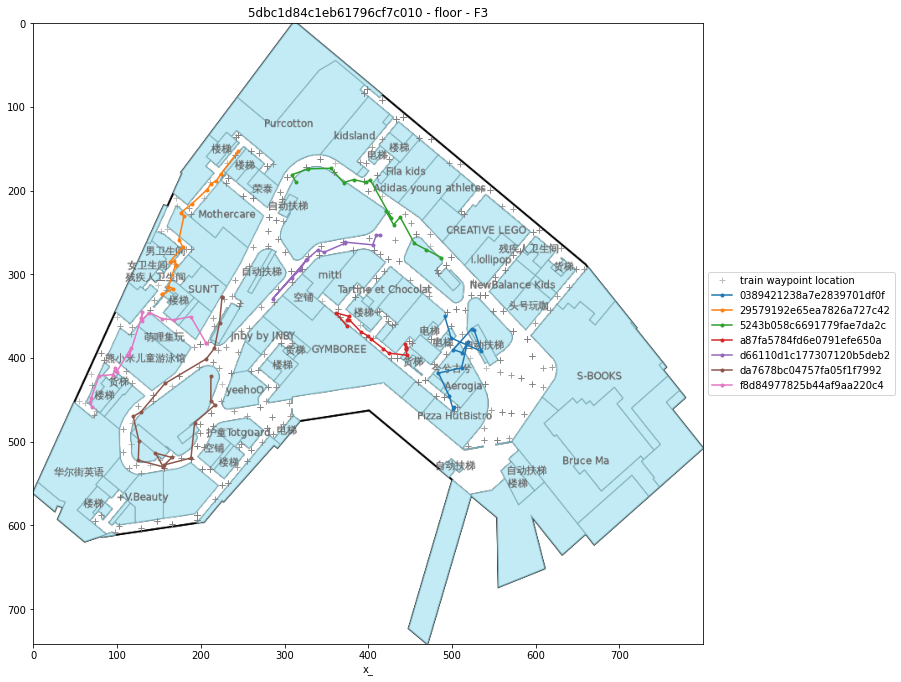

In [62]:
example_site = '5dbc1d84c1eb61796cf7c010'
example_floorNo = 'F3'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5dbc1d84c1eb61796cf7c010 - floor - F3'}, xlabel='x_'>)

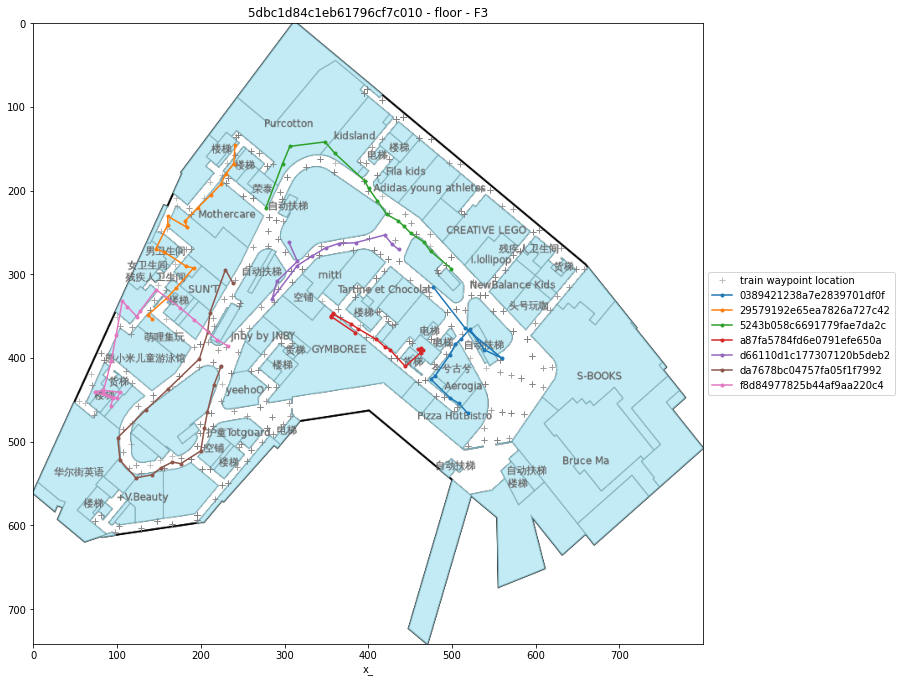

In [63]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5dbc1d84c1eb61796cf7c010 - floor - F3'}, xlabel='x_'>)

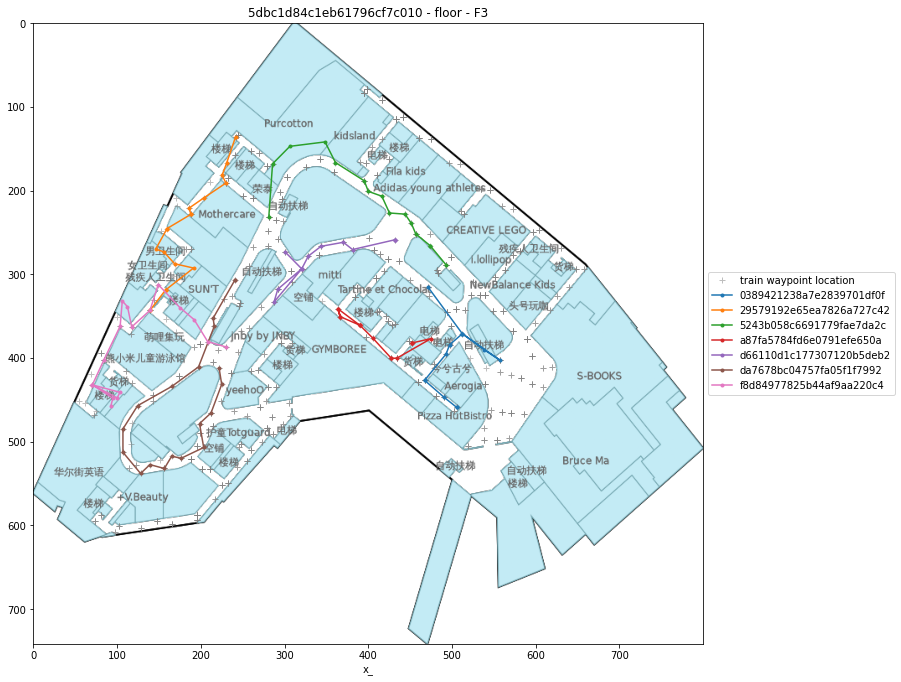

In [64]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)